**Загрузка и подготовка данных**

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

DS_PATH = '/content/drive/MyDrive/Datasets for ORG-4(SentimentAnalysisWithObjectDetection)/'

Mounted at /content/drive


In [24]:
import random
DF = pd.read_csv(DS_PATH + 'women_with_predict.csv',encoding='utf-8',lineterminator='\n')

data = DF[['text','label']]
data = data.dropna()

data_l0 = data.loc[DF['label'] == 0]
data_l1 = data.loc[DF['label'] == 1]
data_l2 = data.loc[DF['label'] == 2]
data_l = [[data_l0, 0], [data_l1, 0], [data_l2, 0]]
data = pd.DataFrame(columns=['text', 'label'] )

min_count_of_entries_in_labels = min(len(data_l0), len(data_l1), len(data_l2))
for i in range(min_count_of_entries_in_labels * 3):
  j = random.randint(0,2)
  data = data.append(data_l[j][0].iloc[data_l[j][1]])
  if data_l[j][1] < min_count_of_entries_in_labels - 1:
    data_l[j][1] += 1

tmp = round(len(data)* 0.5)
tmp_1 = round(len(data) * 0.6)

train_data = data.iloc[0:tmp]
val_data = data.iloc[tmp:tmp_1]
test_data = data.iloc[tmp_1:round(len(data) * 0.7)]

train_text = train_data['text'].astype('str')
train_labels = train_data['label'].astype('int')
val_text = val_data['text'].astype('str')
val_labels = val_data['label'].astype('int')
test_text = test_data['text'].astype('str')
test_labels = test_data['label'].astype('int')

**Подключение библиотек**

In [9]:
!pip install transformers
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

**Загрузка токенизатора с модели xlm-roberta-base**

**График длин отзывов**

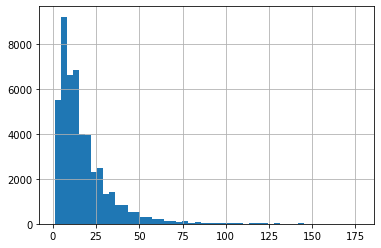

In [ ]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 50)

**Токенизация данных**

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tokens_train = tokenizer.batch_encode_plus(
    list(train_text.values),
    max_length = 65,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    list(val_text.values),
    max_length = 65,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    list(test_text.values),
    max_length = 65,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 32


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

test_data = TensorDataset(test_seq, test_mask)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

**Загружаем модель xlm-roberta-base, добавляем 3 выхода**

In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("xlm-roberta-base", 
                                                      num_labels = 3, 
                                                      output_attentions = False,
                                                      output_hidden_states = False)

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.9.attention.self.value.bias', 'lm_head.decoder.weight', 'roberta.encoder.layer.6.intermediate.dense.bias', 'roberta.encoder.layer.1.attention.self.key.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.6.output.dense.weight', 'roberta.encoder.layer.7.attention.self.value.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.7.attention.self.query.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.dense.weight', 'roberta.encoder.layer.8.attention.self.query.weight', 'roberta.encoder.layer.1.intermediate.dense.bias', 'roberta.encoder.layer.5.attention.self.query.bias', 'roberta.encoder.layer.5.attention.output.LayerNorm.bias', 'ro

In [18]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [26]:
from transformers import get_linear_schedule_with_warmup

n_epochs = 3

n_steps = len(train_dataloader) * n_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = n_steps)

**Дообучение модели на датасете**

In [27]:
from datetime import timedelta
import time
from sklearn.metrics import classification_report
import numpy as np

device = torch.device("cuda")
seed = 42
random.seed = (seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
model.cuda()

losses = []

for epoch in range(n_epochs):
    print("Training:")
    start = time.time()
    mean_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        
        torch.cuda.empty_cache()
        if (step + 1) % 100 == 0:
            duration = timedelta(seconds=int(time.time() - start))
            print('Batch {:>5,}  of  {:>5,}.    Time: {:}.'.format(step + 1, len(train_dataloader), duration))
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_targets = batch[2].to(device)
        model.zero_grad()
        
        torch.cuda.empty_cache()
        outputs = model(b_input_ids, attention_mask=b_attention_masks, labels = b_targets)
        loss = outputs[0]
        
        mean_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        mean_loss = mean_loss / len(train_dataloader)
    
    losses.append(mean_loss)
    print("Mean loss: " , mean_loss)
    print("Training epoch took:" , timedelta(seconds=int(time.time() - start)))
    
    print()
    print("Validation:")
    model.eval()
    
    start = time.time()
    predictions = torch.Tensor().to(dtype=torch.int8)
    
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_attention_masks = batch[1].to(device)
        b_targets = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_attention_masks, output_hidden_states=False, output_attentions=False, return_dict=True)
        
        predictions = torch.cat((predictions, outputs.logits.cpu().argmax(axis=1)))
        torch.cuda.empty_cache()
        
    print(classification_report(val_y, predictions))
    print("Validation took: {:}".format(timedelta(seconds = int(time.time() - start))))
    print()

Training:
Batch   100  of  1,258.    Time: 0:00:43.
Batch   200  of  1,258.    Time: 0:01:28.
Batch   300  of  1,258.    Time: 0:02:15.
Batch   400  of  1,258.    Time: 0:03:01.
Batch   500  of  1,258.    Time: 0:03:47.
Batch   600  of  1,258.    Time: 0:04:33.
Batch   700  of  1,258.    Time: 0:05:20.
Batch   800  of  1,258.    Time: 0:06:06.
Batch   900  of  1,258.    Time: 0:06:52.
Batch 1,000  of  1,258.    Time: 0:07:38.
Batch 1,100  of  1,258.    Time: 0:08:24.
Batch 1,200  of  1,258.    Time: 0:09:10.
Mean loss:  0.0005819070373648757
Training epoch took: 0:09:37

Validation:
              precision    recall  f1-score   support

           0       0.60      0.66      0.63      2711
           1       0.91      0.78      0.84      2664
           2       0.70      0.73      0.71      2674

    accuracy                           0.72      8049
   macro avg       0.74      0.72      0.73      8049
weighted avg       0.73      0.72      0.73      8049

Validation took: 0:00:34

Tra

**Тестирование модели**

In [28]:
print("Testing:")
model.eval()

t0 = time.time()
predictions = torch.Tensor().to(dtype=torch.int8)

for batch in test_dataloader:

    b_input_ids = batch[0].to(device)
    b_attention_masks = batch[1].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_attention_masks, output_hidden_states=False, output_attentions=False, return_dict=True)

    predictions = torch.cat((predictions, outputs.logits.cpu().argmax(axis=1)))

print(classification_report(test_y ,predictions))

Testing:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      2730
           1       0.89      0.84      0.86      2729
           2       0.74      0.71      0.72      2591

    accuracy                           0.75      8050
   macro avg       0.76      0.75      0.75      8050
weighted avg       0.76      0.75      0.75      8050

